In [2]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import resnet18
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/Human', transform=transform)


# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [3]:
model = resnet18(pretrained=True)

In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
class CamResNet(nn.Module):
    def __init__(self):
        super(CamResNet, self).__init__()
        
        # 가장 마지막 가져오기
        model = resnet18(pretrained=True)
        
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        
        self.avgpool = model.avgpool
        self.fc = model.fc
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        feature_map = x
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x, feature_map

In [6]:
# initialize the VGG model
resnet = CamResNet()

# set the evaluation mode
resnet.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

print(resnet)

# get the most likely prediction of the model
pred, last_feature_map = resnet(img) # 결과

print(torch.argmax(pred)) # class와 일치하는지 확인
print(pred.shape)

CamResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 512, 7, 7])
shape of heatmap: torch.Size([7, 7])
tensor([[ 34.2701,  52.2981,  60.2177,  68.5177,  60.5820,  52.9526,  33.9031],
        [ 44.4956,  67.5237,  76.9515,  87.8028,  82.2606,  77.7140,  49.9733],
        [ 43.9909,  61.3537,  68.6714,  78.9987,  79.6317,  75.9382,  49.4247],
        [ 43.7989,  60.4370,  64.0842,  78.6359,  86.6850,  82.9594,  58.8676],
        [ 45.9408,  68.1579,  72.0171, 106.4136, 127.7794, 119.9740,  82.8457],
        [ 51.5717,  82.6659, 111.4603, 163.4367, 192.7101, 171.1753, 110.8705],
        [ 38.1457,  63.3933,  97.5385, 135.3071, 160.2713, 142.9570,  94.0808]],
       grad_fn=<SqueezeBackward0>)


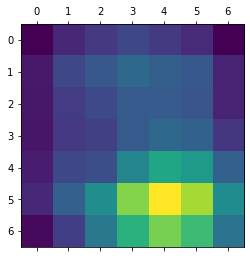

In [7]:
print(last_feature_map.shape)

pooled_weights = torch.sum(last_feature_map, dim=[0, 2, 3])

# 각 채널 별 가중치를 곱해준다.
for i in range(512):
    last_feature_map[:, i, :, :] *= pooled_weights[i]
    

heatmap = torch.mean(last_feature_map, dim=1).squeeze()   # 채널 dimension으로 평균을 구하면 heatmap이 된다.
print("shape of heatmap:", heatmap.shape)
print(heatmap)
heatmap = np.maximum(heatmap.detach(), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)


# draw the heatmap
plt.matshow(heatmap.squeeze())

In [8]:
print(img.shape)

torch.Size([1, 3, 224, 224])


In [9]:
def imshow(img):
    print("shape of the image: ", img.shape)
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of the image:  torch.Size([3, 224, 224])


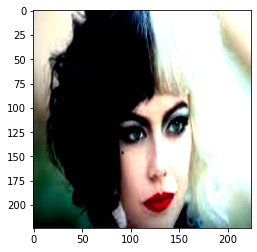

In [10]:
import cv2
from PIL import Image

imshow(img[0])

In [11]:
import cv2
img = cv2.imread('./data/Human/data/human.jpg')
print(img.shape)
heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

(168, 300, 3)


True

In [12]:
img = cv2.imread('./map.jpg', cv2.IMREAD_COLOR)

cv2.imshow('Color', img)
cv2.waitKey(0)
cv2.destroyAllWindows()